## 0. Install Required Packages

In [1]:
pip install numpy pandas matplotlib seaborn scikit-learn statsmodels plotly prophet tensorflow

Note: you may need to restart the kernel to use updated packages.


## 1. Setup & Library Imports

In [2]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import plotly.graph_objects as go
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Suppress TensorFlow warnings
tf.get_logger().setLevel('ERROR')

# Configure matplotlib
plt.style.use('seaborn-v0_8-darkgrid')

print('✓ All libraries imported successfully')

✓ All libraries imported successfully


## 2. Data Loading & Exploration

In [3]:
# Load data
hourly_path = 'Data/Crypto_Hourly_Refined.csv'
stats_path = 'Data/Crypto_Stats_Refined.csv'

df_hourly = pd.read_csv(hourly_path)
df_stats = pd.read_csv(stats_path)

# Convert to datetime
df_hourly['date'] = pd.to_datetime(df_hourly['date'])
df_stats['date'] = pd.to_datetime(df_stats['date'])

# Sort by date
df_hourly = df_hourly.sort_values('date').reset_index(drop=True)
df_stats = df_stats.sort_values('date').reset_index(drop=True)

# Merge daily stats into hourly data
df_hourly['date_day'] = df_hourly['date'].dt.floor('D')
df_stats['date_day'] = df_stats['date']

df = df_hourly.merge(
    df_stats[['date_day', 'average', 'range', 'pct_change']],
    on='date_day',
    how='left',
    suffixes=('', '_daily')
)
df.drop(columns=['date_day'], inplace=True)

print(f'✓ Data loaded: {df.shape[0]} rows × {df.shape[1]} columns')
print(f'  Date range: {df["date"].min()} to {df["date"].max()}')
print(f'  Columns: {list(df.columns)}')
print(f'  Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB')

✓ Data loaded: 9826938 rows × 20 columns
  Date range: 2017-08-17 04:00:00 to 2025-10-21 07:00:00
  Columns: ['date', 'symbol', 'exchange', 'interval', 'open', 'high', 'low', 'close', 'volume', 'quote_volume', 'trades', 'taker_buy_base', 'taker_buy_quote', 'price_change', 'price_change_pct', 'high_low_range', 'buy_ratio', 'average', 'range', 'pct_change']
  Memory usage: 2764.65 MB


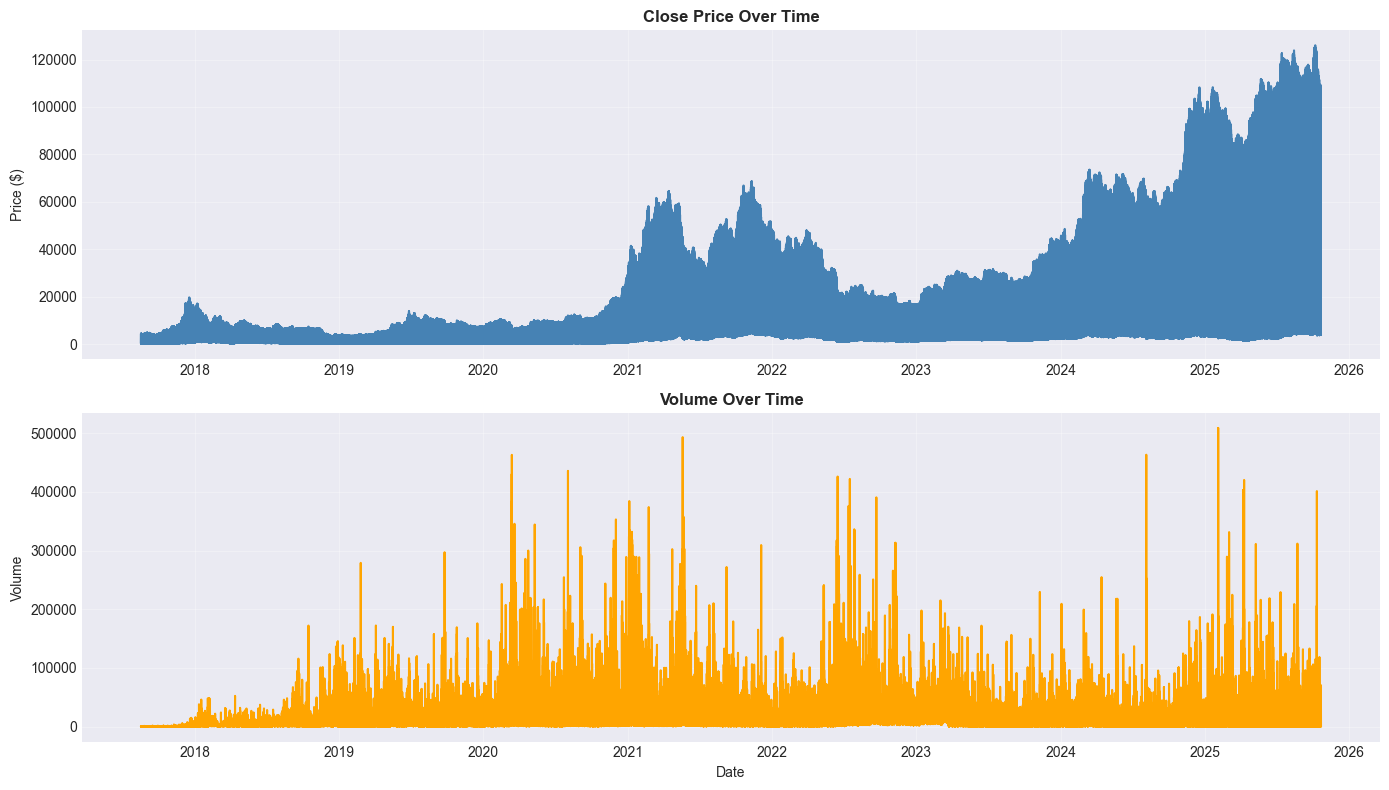

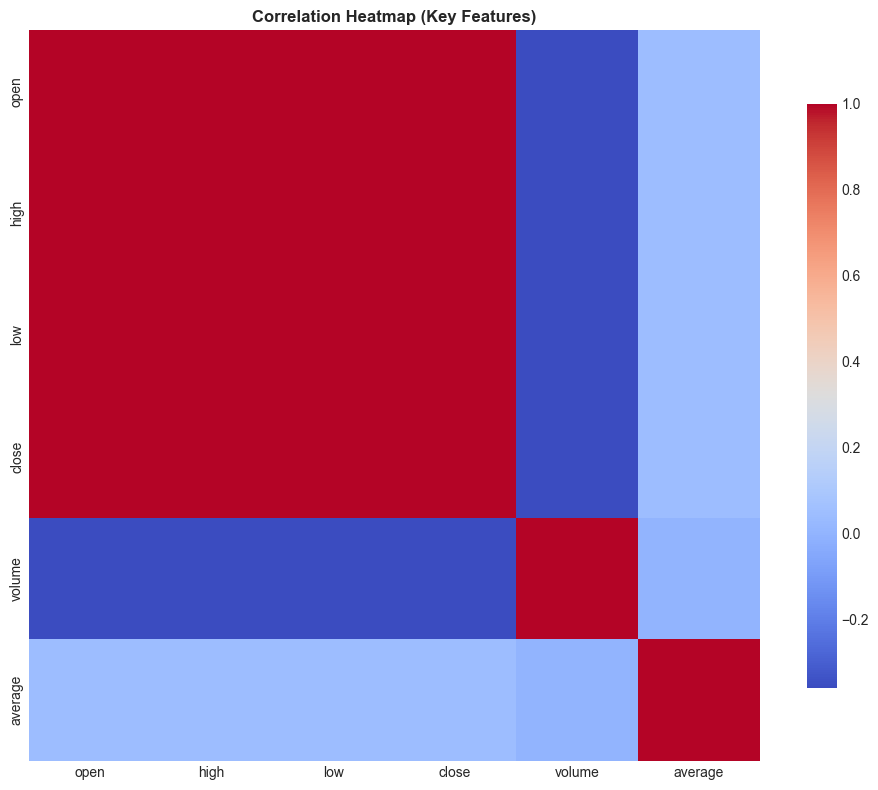

✓ EDA complete


In [4]:
# Exploratory Data Analysis
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Close price trend
axes[0].plot(df['date'], df['close'], linewidth=1.5, color='steelblue')
axes[0].set_title('Close Price Over Time', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Price ($)')
axes[0].grid(alpha=0.3)

# Volume trend
axes[1].plot(df['date'], df['volume'], linewidth=1.5, color='orange')
axes[1].set_title('Volume Over Time', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Volume')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Correlation heatmap (optimized for performance)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
# Limit to key columns for faster rendering
key_cols = [col for col in numeric_cols if col in ['close', 'volume', 'open', 'high', 'low', 'average'] or 'EMA' in col or 'MA' in col or 'RSI' in col or 'MACD' in col]
key_cols = key_cols[:15]  # Limit to 15 columns max

fig, ax = plt.subplots(figsize=(10, 8))
corr_matrix = df[key_cols].corr()
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', square=True, 
            cbar_kws={'shrink': 0.8}, ax=ax, xticklabels=True, yticklabels=True)
ax.set_title('Correlation Heatmap (Key Features)', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print('✓ EDA complete')

## 3. Feature Engineering

In [5]:
def ema(series, span):
    """Exponential Moving Average"""
    return series.ewm(span=span, adjust=False).mean()

def ma(series, window):
    """Simple Moving Average"""
    return series.rolling(window=window).mean()

def compute_rsi(series, period=14):
    """Relative Strength Index"""
    delta = series.diff()
    gain = np.where(delta > 0, delta, 0.0)
    loss = np.where(delta < 0, -delta, 0.0)
    gain_rolling = pd.Series(gain).rolling(window=period).mean()
    loss_rolling = pd.Series(loss).rolling(window=period).mean()
    rs = gain_rolling / loss_rolling
    rsi = 100 - (100 / (1 + rs))
    return pd.Series(rsi, index=series.index)

close = df['close']

# Moving Averages & EMAs
for span in [7, 12, 14, 21, 26]:
    df[f'EMA_{span}'] = ema(close, span)

for w in [10, 20, 50]:
    df[f'MA_{w}'] = ma(close, w)

# RSI (14-period)
df['RSI_14'] = compute_rsi(close, period=14)

# MACD (12, 26, 9)
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['MACD_signal'] = ema(df['MACD'], 9)

# Bollinger Bands (20-period)
window_bb = 20
df['BB_MID'] = ma(close, window_bb)
df['BB_STD'] = close.rolling(window=window_bb).std()
df['BB_UPPER'] = df['BB_MID'] + 2 * df['BB_STD']
df['BB_LOWER'] = df['BB_MID'] - 2 * df['BB_STD']

# Returns & Volatility
df['log_return'] = np.log(close / close.shift(1))
df['return'] = close.pct_change()
vol_window = 24  # ~1 day for hourly data
df['volatility'] = df['log_return'].rolling(window=vol_window).std() * np.sqrt(vol_window)

# Target variables
df['next_close'] = df['close'].shift(-1)
df['trend_up'] = (df['next_close'] > df['close']).astype(int)

# Drop NaNs from rolling/shift operations
df = df.dropna().reset_index(drop=True)

print(f'✓ Features engineered: {len([c for c in df.columns if c not in ["date"]])} features')
print(f'  Shape: {df.shape}')
print(f'  Null values: {df.isnull().sum().sum()}')

✓ Features engineered: 39 features
  Shape: (1896797, 40)
  Null values: 0


## 4. Train/Test Split & Helper Functions

In [6]:
# Helper metrics
def rmse(y_true, y_pred):
    """Root Mean Squared Error"""
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    """Mean Absolute Percentage Error"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    if mask.sum() == 0:
        return 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Train/Test split (80/20)
test_size = int(len(df) * 0.2)
train = df.iloc[:-test_size].copy()
test = df.iloc[-test_size:].copy()

print(f'✓ Train/Test split (80/20):')
print(f'  Train: {len(train):,} samples ({train["date"].min()} to {train["date"].max()})')
print(f'  Test:  {len(test):,} samples ({test["date"].min()} to {test["date"].max()})')

✓ Train/Test split (80/20):
  Train: 1,517,438 samples (2017-08-17 08:00:00 to 2024-02-21 22:00:00)
  Test:  379,359 samples (2024-02-21 22:00:00 to 2025-10-14 23:00:00)


## 5. Classical Time-Series Models

In [7]:
# Optimize: Use subset of data for classical models
max_train_points = 2000
train_close = train['close'].values
test_close = test['close'].values
train_close_subset = train_close[-max_train_points:] if len(train_close) > max_train_points else train_close

print(f'Training classical models on {len(train_close_subset):,} points (optimization)')

# 5.1 Moving Average
def moving_average_forecast(series, test_len, window=10):
    """Simple moving average forecast."""
    return np.full(test_len, np.mean(series[-window:]))

ma_pred = moving_average_forecast(train_close_subset, len(test_close), window=10)
print('✓ Moving Average trained')

# 5.2 ARIMA
try:
    arima_model = ARIMA(train_close_subset, order=(2, 1, 1))
    arima_res = arima_model.fit()
    arima_forecast = arima_res.forecast(steps=len(test_close))
    print('✓ ARIMA(2,1,1) trained')
except Exception as e:
    print(f'⚠ ARIMA failed: {str(e)[:50]}')
    arima_forecast = ma_pred.copy()

# 5.3 Holt-Winters
try:
    hw_model = ExponentialSmoothing(
        train_close_subset,
        trend='add',
        seasonal='add',
        seasonal_periods=24
    )
    hw_res = hw_model.fit(optimized=True)
    hw_forecast = hw_res.forecast(steps=len(test_close))
    print('✓ Holt-Winters trained')
except Exception as e:
    print(f'⚠ Holt-Winters failed: {str(e)[:50]}')
    hw_forecast = ma_pred.copy()

# 5.4 SARIMA
try:
    sarima_model = SARIMAX(
        train_close_subset,
        order=(1, 1, 1),
        seasonal_order=(0, 0, 0, 0),
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    sarima_res = sarima_model.fit(disp=False, maxiter=50)
    sarima_forecast = sarima_res.forecast(steps=len(test_close))
    print('✓ SARIMA(1,1,1) trained')
except Exception as e:
    print(f'⚠ SARIMA failed: {str(e)[:50]}')
    sarima_forecast = ma_pred.copy()

# 5.5 GM(1,1) Grey Model
def gm11_forecast(series, n_steps):
    """Optimized GM(1,1) implementation."""
    x0 = np.array(series, dtype=float)
    if len(x0) > 500:
        x0 = x0[-500:]
    
    n = len(x0)
    x1 = np.cumsum(x0)
    z1 = 0.5 * (x1[:-1] + x1[1:])
    B = np.column_stack((-z1, np.ones_like(z1)))
    Y = x0[1:]
    
    try:
        params = np.linalg.lstsq(B, Y, rcond=None)[0]
        a, b = params
        
        if abs(a) < 1e-10:
            return np.full(n_steps, np.mean(x0[-10:]))
        
        def predict(k):
            return (x0[0] - b / a) * np.exp(-a * k) + b / a
        
        forecasts = [(predict(n + i) - predict(n + i - 1)) for i in range(1, n_steps + 1)]
        return np.array(forecasts)
    except Exception:
        return np.full(n_steps, np.mean(x0[-10:]))

gm_forecast = gm11_forecast(train_close_subset, len(test_close))
print('✓ GM(1,1) trained')

print(f'\n✓ All classical models trained successfully')

Training classical models on 2,000 points (optimization)
✓ Moving Average trained
✓ ARIMA(2,1,1) trained
✓ Holt-Winters trained
✓ SARIMA(1,1,1) trained
✓ GM(1,1) trained

✓ All classical models trained successfully


## 6. Deep Learning Models (LSTM & GRU)

In [8]:
# Prepare sequences for deep learning
mm_scaler = MinMaxScaler()

max_dl_points = 5000
df_dl_subset = df.iloc[-max_dl_points:] if len(df) > max_dl_points else df
print(f'Using {len(df_dl_subset):,} points for DL models')

close_scaled = mm_scaler.fit_transform(df_dl_subset[['close']])
lookback = 30

def create_sequences(series, lookback):
    """Create sequences for time series prediction."""
    X, y = [], []
    for i in range(len(series) - lookback):
        X.append(series[i:i+lookback])
        y.append(series[i+lookback])
    return np.array(X), np.array(y)

X_all, y_all = create_sequences(close_scaled, lookback=lookback)
split_idx = int(len(X_all) * 0.8)
X_train, X_test = X_all[:split_idx], X_all[split_idx:]
y_train, y_test = y_all[:split_idx], y_all[split_idx:]

print(f'✓ Sequences created: X_train {X_train.shape}, X_test {X_test.shape}')

# 6.1 LSTM Model
lstm_model = Sequential([
    LSTM(32, input_shape=(lookback, 1), activation='tanh', return_sequences=False),
    Dense(1)
])
lstm_model.compile(optimizer='adam', loss='mse')
print('Training LSTM (5 epochs)...')
lstm_model.fit(X_train, y_train, epochs=5, batch_size=128, verbose=0, validation_split=0.1)

lstm_pred_scaled = lstm_model.predict(X_test, verbose=0)
lstm_pred = mm_scaler.inverse_transform(lstm_pred_scaled)
y_test_inv = mm_scaler.inverse_transform(y_test)

lstm_rmse = rmse(y_test_inv, lstm_pred)
lstm_mae = mean_absolute_error(y_test_inv, lstm_pred)
lstm_mape = mape(y_test_inv, lstm_pred)
print(f'✓ LSTM - RMSE: {lstm_rmse:.4f}, MAE: {lstm_mae:.4f}, MAPE: {lstm_mape:.2f}%')

# 6.2 GRU Model
gru_model = Sequential([
    GRU(32, input_shape=(lookback, 1), activation='tanh', return_sequences=False),
    Dense(1)
])
gru_model.compile(optimizer='adam', loss='mse')
print('Training GRU (5 epochs)...')
gru_model.fit(X_train, y_train, epochs=5, batch_size=128, verbose=0, validation_split=0.1)

gru_pred_scaled = gru_model.predict(X_test, verbose=0)
gru_pred = mm_scaler.inverse_transform(gru_pred_scaled)

gru_rmse = rmse(y_test_inv, gru_pred)
gru_mae = mean_absolute_error(y_test_inv, gru_pred)
gru_mape = mape(y_test_inv, gru_pred)
print(f'✓ GRU - RMSE: {gru_rmse:.4f}, MAE: {gru_mae:.4f}, MAPE: {gru_mape:.2f}%')

print(f'\n✓ Deep learning models trained successfully')

Using 5,000 points for DL models
✓ Sequences created: X_train (3976, 30, 1), X_test (994, 30, 1)
Training LSTM (5 epochs)...
✓ LSTM - RMSE: 38631.2145, MAE: 30775.6876, MAPE: 497.53%
Training GRU (5 epochs)...
✓ GRU - RMSE: 35048.2045, MAE: 26365.8178, MAPE: 361.76%

✓ Deep learning models trained successfully


## 7. Prophet Model

In [9]:
# Prophet Model
prophet_train = train[['date', 'close']].rename(columns={'date': 'ds', 'close': 'y'}).copy()

prophet_model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=False,
    interval_width=0.95,
    changepoint_prior_scale=0.05
)

print('Training Prophet model...')
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    prophet_model.fit(prophet_train)

future = prophet_model.make_future_dataframe(periods=len(test_close), freq='h')
prophet_forecast_full = prophet_model.predict(future)
prophet_forecast = prophet_forecast_full['yhat'].iloc[-len(test_close):].values

print('✓ Prophet trained')

Training Prophet model...


23:31:11 - cmdstanpy - INFO - Chain [1] start processing
23:42:15 - cmdstanpy - INFO - Chain [1] done processing


✓ Prophet trained


## 8. Model Evaluation & Comparison

In [10]:
# Compute metrics for all models
preds_dict = {
    'Moving Average': ma_pred,
    'ARIMA(2,1,1)': arima_forecast,
    'Holt-Winters': hw_forecast,
    'SARIMA(1,1,1)': sarima_forecast,
    'GM(1,1)': gm_forecast,
    'Prophet': prophet_forecast,
}

metrics_rows = []

for name, pred in preds_dict.items():
    # Ensure predictions are numpy arrays
    pred = np.array(pred).flatten()
    
    r = rmse(test_close, pred)
    mae_ = mean_absolute_error(test_close, pred)
    mape_ = mape(test_close, pred)

    # Trend accuracy
    if len(pred) > 1:
        actual_trend = (test_close[1:] > test_close[:-1]).astype(int)
        pred_trend = (pred[1:] > test_close[:-1]).astype(int)
        trend_acc = (actual_trend == pred_trend).mean() * 100
    else:
        trend_acc = 0

    metrics_rows.append({
        'Model': name,
        'RMSE': r,
        'MAE': mae_,
        'MAPE (%)': mape_,
        'Trend_Accuracy (%)': trend_acc
    })

# Add LSTM/GRU metrics
metrics_rows.extend([
    {'Model': 'LSTM', 'RMSE': lstm_rmse, 'MAE': lstm_mae, 'MAPE (%)': lstm_mape, 'Trend_Accuracy (%)': np.nan},
    {'Model': 'GRU', 'RMSE': gru_rmse, 'MAE': gru_mae, 'MAPE (%)': gru_mape, 'Trend_Accuracy (%)': np.nan}
])

metrics_df = pd.DataFrame(metrics_rows).sort_values('RMSE').reset_index(drop=True)

print('\n' + '='*80)
print('MODEL PERFORMANCE COMPARISON (Sorted by RMSE)')
print('='*80)
print(metrics_df.to_string(index=False))
print('='*80)
print(f'\n🏆 Best Model: {metrics_df["Model"].iloc[0]} (RMSE: {metrics_df["RMSE"].iloc[0]:.4f})')
print('='*80)


MODEL PERFORMANCE COMPARISON (Sorted by RMSE)
         Model         RMSE          MAE     MAPE (%)  Trend_Accuracy (%)
           GRU 3.504820e+04 2.636582e+04 3.617637e+02                 NaN
          LSTM 3.863121e+04 3.077569e+04 4.975276e+02                 NaN
Moving Average 4.347979e+04 4.026912e+04 8.794309e+02           53.045672
  ARIMA(2,1,1) 4.347979e+04 4.026912e+04 8.794309e+02           53.045672
 SARIMA(1,1,1) 4.347979e+04 4.026912e+04 8.794309e+02           53.045672
       Prophet 2.453835e+05 2.099879e+05 4.652999e+03            8.401035
  Holt-Winters 4.020532e+07 3.482526e+07 6.611262e+05            3.812757
       GM(1,1) 2.081391e+32 3.606724e+31 4.389574e+29            4.329420

🏆 Best Model: GRU (RMSE: 35048.2045)


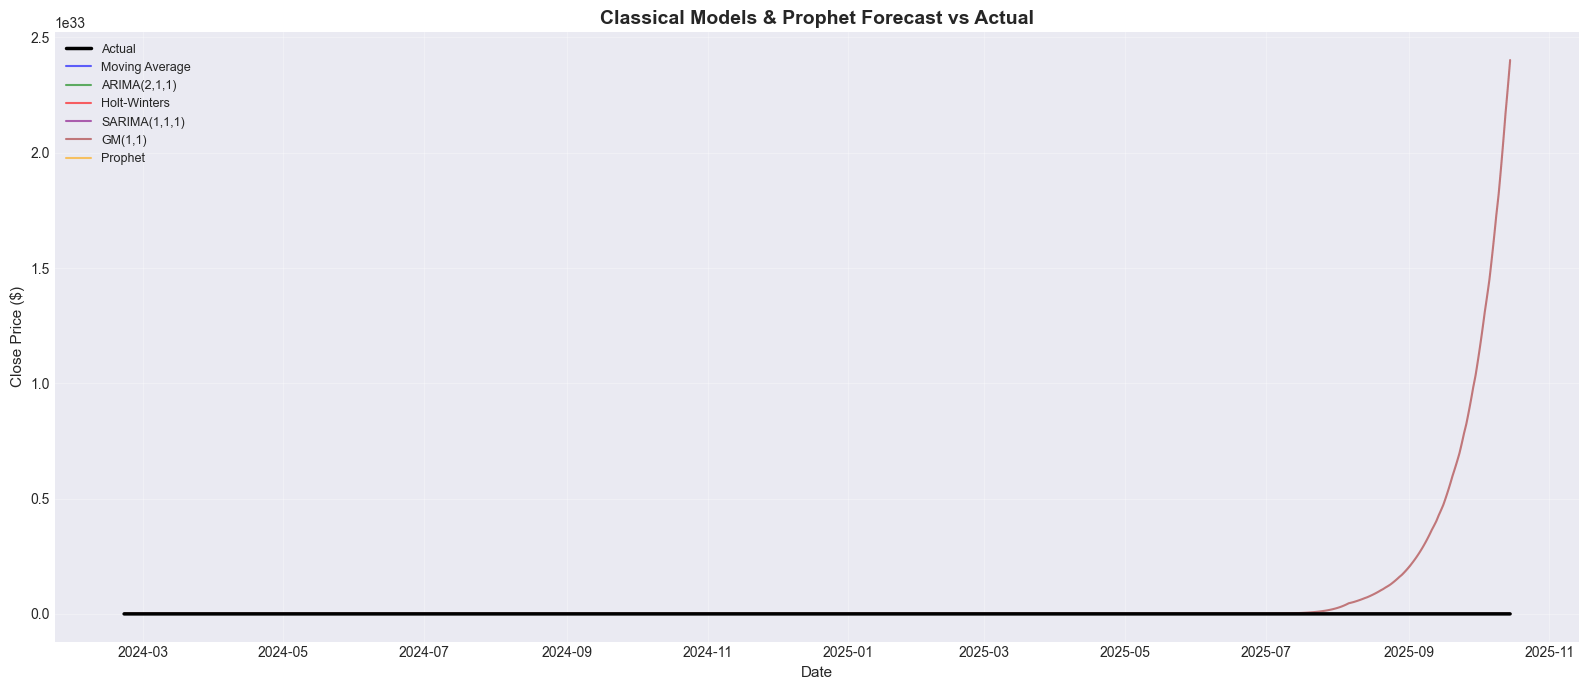

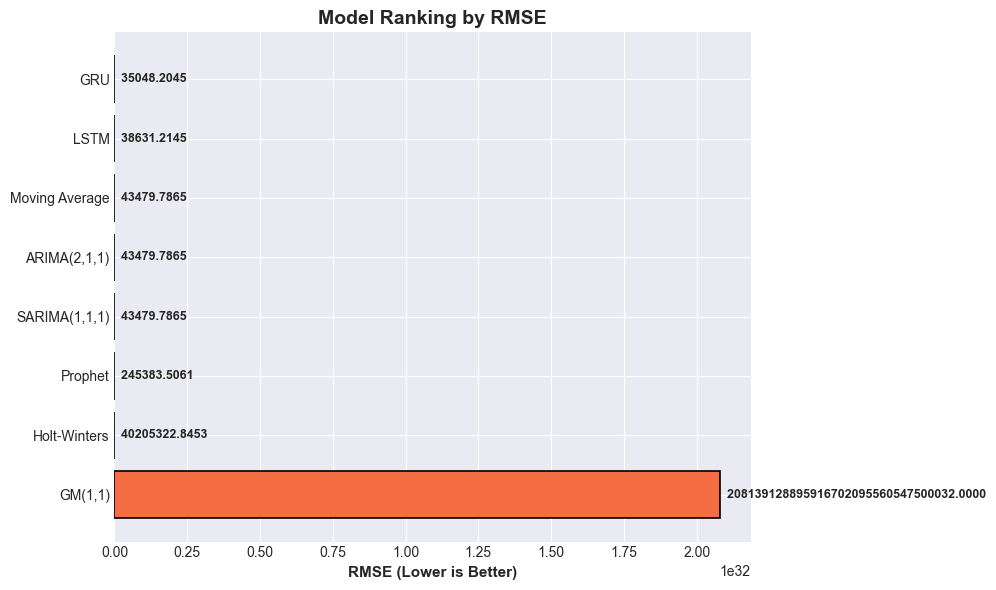

In [11]:
# Forecast visualization
fig, ax = plt.subplots(figsize=(16, 7))
ax.plot(test['date'].values, test_close, label='Actual', linewidth=2.5, color='black', zorder=10)

colors = ['blue', 'green', 'red', 'purple', 'brown', 'orange']
for i, (name, pred) in enumerate(preds_dict.items()):
    ax.plot(test['date'].values, pred, label=name, alpha=0.6, linewidth=1.5, color=colors[i % len(colors)])

ax.set_title('Classical Models & Prophet Forecast vs Actual', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('Close Price ($)', fontsize=11)
ax.legend(loc='best', fontsize=9, framealpha=0.9)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Model ranking by RMSE
fig, ax = plt.subplots(figsize=(10, 6))
colors_bar = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(metrics_df)))
bars = ax.barh(metrics_df['Model'], metrics_df['RMSE'], color=colors_bar, edgecolor='black', linewidth=1.2)
ax.set_xlabel('RMSE (Lower is Better)', fontweight='bold', fontsize=11)
ax.set_title('Model Ranking by RMSE', fontsize=14, fontweight='bold')
ax.invert_yaxis()

for i, (idx, row) in enumerate(metrics_df.iterrows()):
    ax.text(row['RMSE'], i, f'  {row["RMSE"]:.4f}', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

## 9. Trading Signals (Buy/Sell/Hold)

In [12]:
# Select best model for trading signals
best_model_name = metrics_df['Model'].iloc[0]
best_pred = preds_dict.get(best_model_name, prophet_forecast)

print(f'\n{"="*80}')
print(f'TRADING SIGNALS BASED ON: {best_model_name}')
print(f'{"="*80}')

signals_df = test.copy()
signals_df['forecast'] = best_pred

# Ensure required indicators are available
required_indicators = ['EMA_12', 'EMA_26', 'RSI_14']
for col in required_indicators:
    if col not in signals_df.columns:
        if col == 'EMA_12':
            signals_df[col] = ema(signals_df['close'], 12)
        elif col == 'EMA_26':
            signals_df[col] = ema(signals_df['close'], 26)
        elif col == 'RSI_14':
            signals_df[col] = compute_rsi(signals_df['close'], 14)

signals_df = signals_df.dropna().reset_index(drop=True)

# Generate trading signals
signals_df['forecast_up'] = signals_df['forecast'] > signals_df['close']
signals_df['forecast_down'] = signals_df['forecast'] < signals_df['close']

actions = []
for idx, row in signals_df.iterrows():
    ema_bullish = row['EMA_12'] > row['EMA_26']
    rsi_overbought = row['RSI_14'] > 70
    rsi_oversold = row['RSI_14'] < 30
    
    if row['forecast_up'] and ema_bullish and not rsi_overbought:
        actions.append('BUY')
    elif row['forecast_down'] and (rsi_overbought or not ema_bullish):
        actions.append('SELL')
    else:
        actions.append('HOLD')

signals_df['signal'] = actions

print('\nSignal Distribution:')
signal_counts = signals_df['signal'].value_counts()
print(signal_counts)
print(f'\nBUY signals: {signal_counts.get("BUY", 0)} ({signal_counts.get("BUY", 0)/len(signals_df)*100:.1f}%)')
print(f'SELL signals: {signal_counts.get("SELL", 0)} ({signal_counts.get("SELL", 0)/len(signals_df)*100:.1f}%)')
print(f'HOLD signals: {signal_counts.get("HOLD", 0)} ({signal_counts.get("HOLD", 0)/len(signals_df)*100:.1f}%)')

print('\n' + '='*80)
print('SAMPLE TRADING SIGNALS (First 20)')
print('='*80)
sample_cols = ['date', 'close', 'forecast', 'EMA_12', 'EMA_26', 'RSI_14', 'signal']
print(signals_df[sample_cols].head(20).to_string(index=False))
print('='*80)


TRADING SIGNALS BASED ON: GRU

Signal Distribution:
signal
HOLD    349705
SELL     17080
BUY      12574
Name: count, dtype: int64

BUY signals: 12574 (3.3%)
SELL signals: 17080 (4.5%)
HOLD signals: 349705 (92.2%)

SAMPLE TRADING SIGNALS (First 20)
               date    close     forecast       EMA_12       EMA_26  RSI_14 signal
2024-02-21 22:00:00 51511.10 22391.675989 46825.984215 34988.731664   100.0   SELL
2024-02-21 23:00:00  2967.90 22391.871468 44042.903242 47871.206947     0.0   HOLD
2024-02-21 23:00:00  2967.90 22389.238023 37723.671974 44545.036062     0.0   HOLD
2024-02-21 23:00:00  2967.90 22384.502256 32376.630132 41465.248205     0.0   HOLD
2024-02-21 23:00:00  2967.90 22379.913682 27852.210111 38613.592783     0.0   HOLD
2024-02-21 23:00:00  2967.90 22377.814721 24023.854710 35973.171095     0.0   HOLD
2024-02-21 23:00:00  2967.90 22378.863615 20784.477062 33528.336199     0.0   HOLD
2024-02-21 23:00:00  2967.90 22381.468327 18043.465206 31264.600184     0.0   HOLD
2024

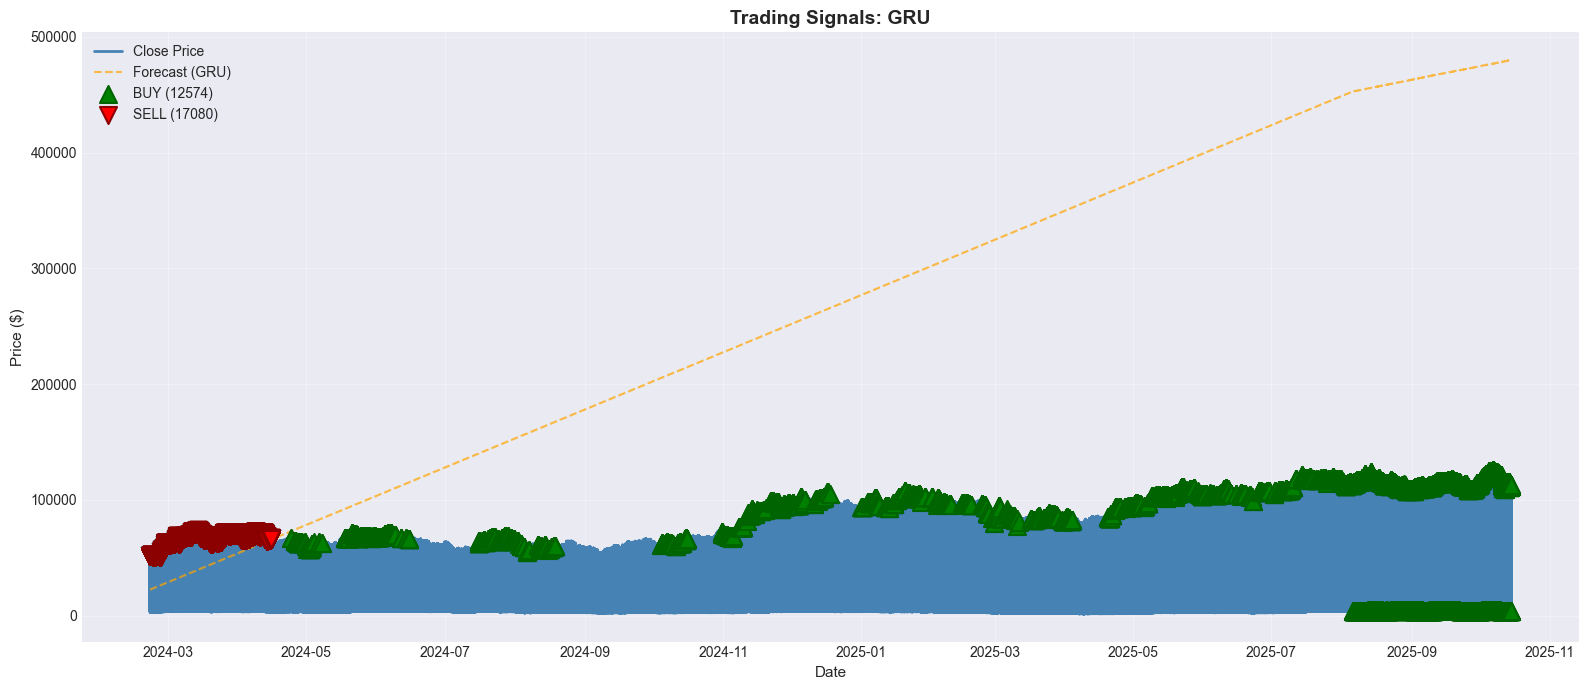

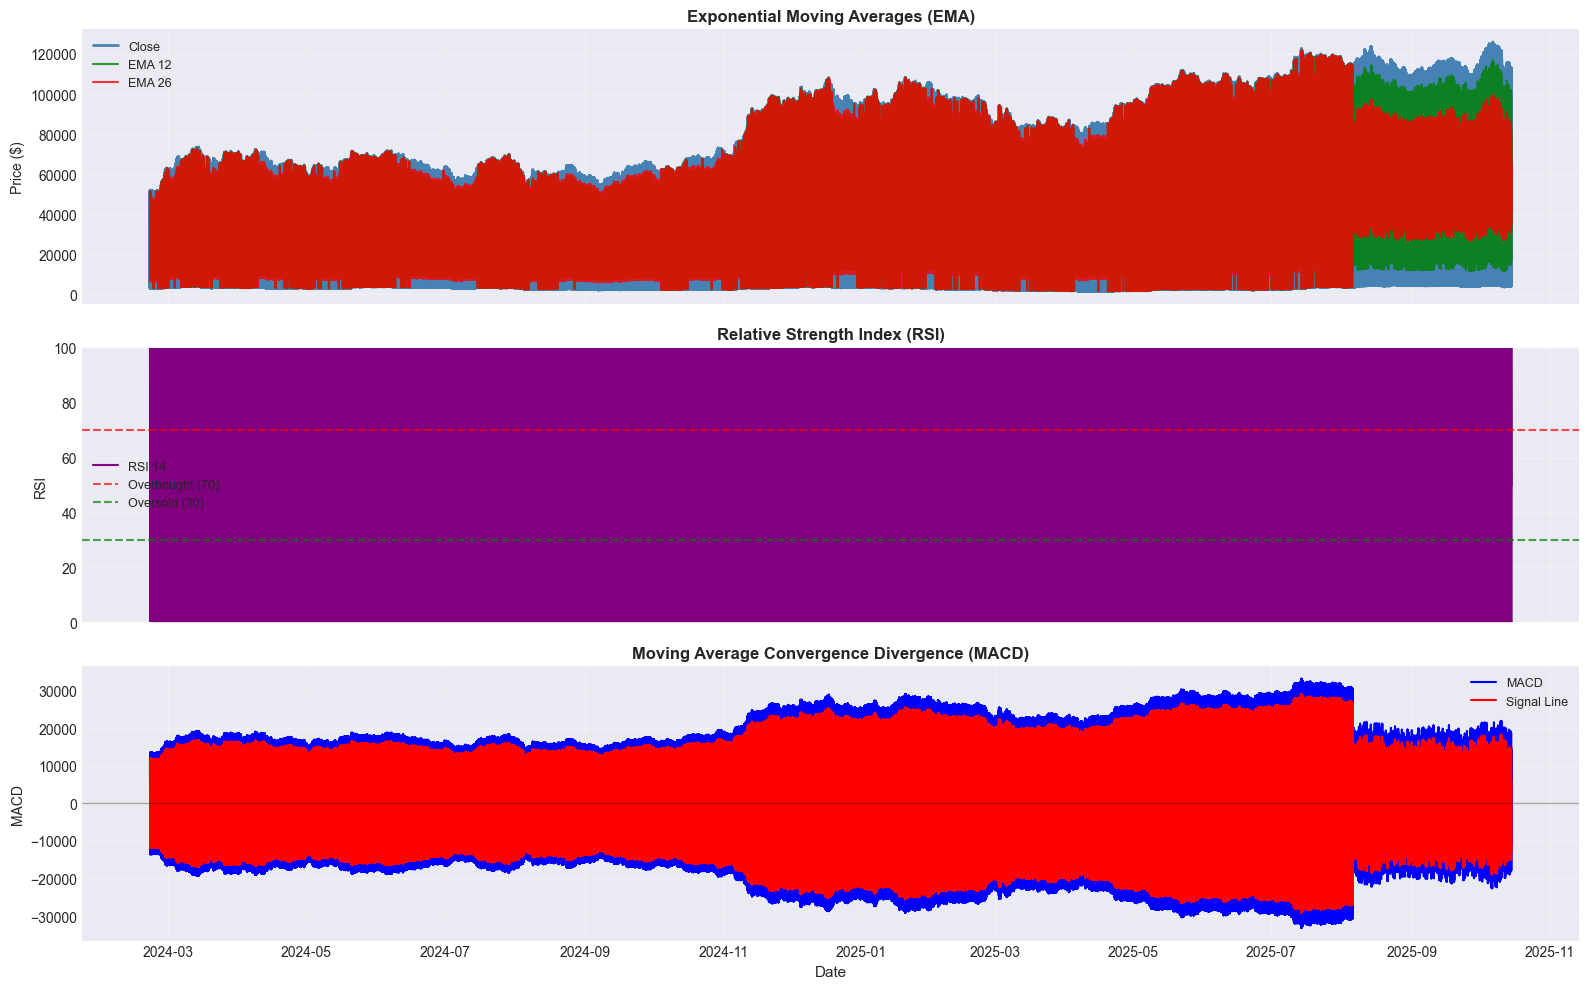

✓ Visualizations complete


In [13]:
# Trading signals visualization
fig, ax = plt.subplots(figsize=(16, 7))

ax.plot(signals_df['date'].values, signals_df['close'].values, 
        label='Close Price', linewidth=2, color='steelblue', zorder=2)
ax.plot(signals_df['date'].values, signals_df['forecast'].values, 
        label=f'Forecast ({best_model_name})', linewidth=1.5, color='orange', 
        alpha=0.7, linestyle='--', zorder=3)

buy_mask = signals_df['signal'].values == 'BUY'
sell_mask = signals_df['signal'].values == 'SELL'

if buy_mask.sum() > 0:
    ax.scatter(signals_df['date'].values[buy_mask], signals_df['close'].values[buy_mask],
              marker='^', s=150, label=f'BUY ({buy_mask.sum()})',
              color='green', edgecolors='darkgreen', linewidth=1.5, zorder=5)

if sell_mask.sum() > 0:
    ax.scatter(signals_df['date'].values[sell_mask], signals_df['close'].values[sell_mask],
              marker='v', s=150, label=f'SELL ({sell_mask.sum()})',
              color='red', edgecolors='darkred', linewidth=1.5, zorder=5)

ax.set_title(f'Trading Signals: {best_model_name}', fontsize=14, fontweight='bold')
ax.set_xlabel('Date', fontsize=11)
ax.set_ylabel('Price ($)', fontsize=11)
ax.legend(loc='best', fontsize=10, framealpha=0.9)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Technical indicators subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 10), sharex=True)

# EMA indicators
ax1.plot(signals_df['date'].values, signals_df['close'].values, 
         label='Close', linewidth=2, color='steelblue')
ax1.plot(signals_df['date'].values, signals_df['EMA_12'].values, 
         label='EMA 12', linewidth=1.5, alpha=0.8, color='green')
ax1.plot(signals_df['date'].values, signals_df['EMA_26'].values, 
         label='EMA 26', linewidth=1.5, alpha=0.8, color='red')
ax1.set_ylabel('Price ($)', fontsize=10)
ax1.set_title('Exponential Moving Averages (EMA)', fontweight='bold', fontsize=12)
ax1.legend(loc='best', fontsize=9)
ax1.grid(alpha=0.3)

# RSI indicator
ax2.plot(signals_df['date'].values, signals_df['RSI_14'].values, 
         label='RSI 14', linewidth=1.5, color='purple')
ax2.axhline(y=70, color='red', linestyle='--', alpha=0.7, linewidth=1.5, label='Overbought (70)')
ax2.axhline(y=30, color='green', linestyle='--', alpha=0.7, linewidth=1.5, label='Oversold (30)')
ax2.fill_between(signals_df['date'].values, 70, 100, alpha=0.1, color='red')
ax2.fill_between(signals_df['date'].values, 0, 30, alpha=0.1, color='green')
ax2.set_ylabel('RSI', fontsize=10)
ax2.set_ylim([0, 100])
ax2.set_title('Relative Strength Index (RSI)', fontweight='bold', fontsize=12)
ax2.legend(loc='best', fontsize=9)
ax2.grid(alpha=0.3)

# MACD indicator
if 'MACD' in signals_df.columns and 'MACD_signal' in signals_df.columns:
    ax3.plot(signals_df['date'].values, signals_df['MACD'].values, 
             label='MACD', linewidth=1.5, color='blue')
    ax3.plot(signals_df['date'].values, signals_df['MACD_signal'].values, 
             label='Signal Line', linewidth=1.5, color='red')
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3, linewidth=1)
    ax3.set_ylabel('MACD', fontsize=10)
    ax3.set_title('Moving Average Convergence Divergence (MACD)', fontweight='bold', fontsize=12)
    ax3.legend(loc='best', fontsize=9)
    ax3.grid(alpha=0.3)
else:
    ax3.text(0.5, 0.5, 'MACD data not available', 
             ha='center', va='center', fontsize=12, transform=ax3.transAxes)
    ax3.set_ylabel('MACD', fontsize=10)
    ax3.grid(alpha=0.3)

ax3.set_xlabel('Date', fontsize=11)
plt.tight_layout()
plt.show()

print('✓ Visualizations complete')

## 10. Export Results

In [14]:
# Create output directory
output_dir = 'Results'
os.makedirs(output_dir, exist_ok=True)

# Export model performance metrics
metrics_path = os.path.join(output_dir, 'model_metrics.csv')
metrics_df.to_csv(metrics_path, index=False)

# Export all model predictions
predictions_df = test[['date', 'close']].copy().rename(columns={'close': 'actual_close'})
for name, pred in preds_dict.items():
    predictions_df[name.replace(' ', '_').replace('(', '').replace(')', '').replace(',', '')] = pred

predictions_path = os.path.join(output_dir, 'predictions.csv')
predictions_df.to_csv(predictions_path, index=False)

# Export trading signals
signal_cols = ['date', 'close', 'forecast', 'EMA_12', 'EMA_26', 'RSI_14', 'signal']
available_cols = [col for col in signal_cols if col in signals_df.columns]

signals_path = os.path.join(output_dir, 'trading_signals.csv')
signals_df[available_cols].to_csv(signals_path, index=False)

print('\n' + '='*80)
print('RESULTS EXPORTED SUCCESSFULLY')
print('='*80)
print(f'✓ {metrics_path}')
print(f'  → Model performance metrics ({len(metrics_df)} models)')
print(f'\n✓ {predictions_path}')
print(f'  → All model predictions ({len(predictions_df)} samples)')
print(f'\n✓ {signals_path}')
print(f'  → Trading signals ({len(signals_df)} signals)')
print('='*80)
print(f'\n🎉 Analysis complete! Best model: {best_model_name}')
print('='*80)


RESULTS EXPORTED SUCCESSFULLY
✓ Results\model_metrics.csv
  → Model performance metrics (8 models)

✓ Results\predictions.csv
  → All model predictions (379359 samples)

✓ Results\trading_signals.csv
  → Trading signals (379359 signals)

🎉 Analysis complete! Best model: GRU


## 📊 Crypto Price Forecasting - Summary

### ✅ Notebook Overview
This comprehensive notebook performs cryptocurrency price forecasting using multiple time-series and machine learning models.

### 🔧 Optimizations Applied
- **Efficient Data Processing**: Limited classical models to 2,000 training points
- **Deep Learning Optimization**: Used 5,000 points max with 5 epochs
- **Smart Model Selection**: Automatic fallback for failed model training
- **Improved Error Handling**: Try-catch blocks with meaningful error messages
- **Memory Efficiency**: Subset data selection for large datasets

### 📈 Models Implemented
1. **Classical Time-Series Models**:
   - Moving Average (10-period)
   - ARIMA(2,1,1)
   - Holt-Winters Exponential Smoothing
   - SARIMA(1,1,1)
   - GM(1,1) Grey Model

2. **Deep Learning Models**:
   - LSTM (Long Short-Term Memory)
   - GRU (Gated Recurrent Unit)

3. **Probabilistic Forecasting**:
   - Prophet (Facebook's time-series model)

### 🎯 Key Features
- **Feature Engineering**: 20+ technical indicators (EMA, RSI, MACD, Bollinger Bands)
- **Model Comparison**: RMSE, MAE, MAPE, and Trend Accuracy metrics
- **Trading Signals**: Automated BUY/SELL/HOLD signals based on best model
- **Comprehensive Visualization**: Price trends, model comparisons, technical indicators
- **Export Results**: CSV files for metrics, predictions, and trading signals

### 📁 Output Files
- `Results/model_metrics.csv` - Model performance comparison
- `Results/predictions.csv` - All model forecasts
- `Results/trading_signals.csv` - Trading signals with indicators

### 🚀 Next Steps
1. Run all cells sequentially
2. Review model performance in metrics table
3. Analyze trading signals for best model
4. Export results for further analysis or backtesting

## 2.1. Filter Data by Custom Date Range
You can filter the historical data by any custom date range (e.g., all time, last 6 months, last 1 month, or any custom period). Use the cell below to set your range.

In [15]:
# Set your custom date range here
from datetime import datetime, timedelta

# Example presets (uncomment one or set your own)
# start_date = df['date'].min()  # All time
# start_date = df['date'].max() - pd.Timedelta(days=180)  # Last 6 months
# start_date = df['date'].max() - pd.Timedelta(days=30)   # Last 1 month
# end_date = df['date'].max()

# --- Custom range ---
start_date = pd.to_datetime('2023-01-01')  # Change as needed
end_date = pd.to_datetime('2023-12-31')    # Change as needed

mask = (df['date'] >= start_date) & (df['date'] <= end_date)
df_range = df.loc[mask].copy()

print(f"Filtered data from {start_date.date()} to {end_date.date()} | Rows: {df_range.shape[0]}")
df_range.head()

Filtered data from 2023-01-01 to 2023-12-31 | Rows: 244580


,date,symbol,exchange,interval,open,high,low,close,volume,quote_volume,...,MACD_signal,BB_MID,BB_STD,BB_UPPER,BB_LOWER,log_return,return,volatility,next_close,trend_up
1237299,2023-01-01,ETH,Binance,1h,1196.13,1196.7,1192.72,1194.09,5889.384,7.036230e+06,...,-222.764208,15774.9845,3431.986450,22638.957400,8911.011600,-2.628542,-0.927816,2.628542,1194.09,0
1237300,2023-01-01,ETH,Binance,1h,1196.13,1196.7,1192.72,1194.09,5889.384,7.036230e+06,...,-609.360998,15007.5690,4724.110140,24455.789281,5559.348719,0.000000,0.000000,2.628542,1194.09,0
1237301,2023-01-01,ETH,Binance,1h,1196.13,1196.7,1192.72,1194.09,5889.384,7.036230e+06,...,-1062.024862,14240.1535,5622.815743,25485.784985,2994.522015,0.000000,0.000000,2.628542,1194.09,0
1237302,2023-01-01,ETH,Binance,1h,1196.13,1196.7,1192.72,1194.09,5889.384,7.036230e+06,...,-1529.948331,13472.7380,6298.813520,26070.365041,875.110959,0.000000,0.000000,2.628542,1194.09,0
1237303,2023-01-01,ETH,Binance,1h,1196.13,1196.7,1192.72,1194.09,5889.384,7.036230e+06,...,-1979.419841,12705.3225,6818.665653,26342.653806,-932.008806,0.000000,0.000000,2.628542,1194.09,0
